# Prediction of asking price for houses on Funda

In this notebook we show how one can predict the prices of houses on funda.

## Importing Libraries

In [1]:
#pip install pyarrow

In [2]:
#!pip install plotnine

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from plotnine import *
import os
import datetime
import pickle
import json
from sklearn.ensemble import RandomForestRegressor


In [4]:
#Importing tools to display outputs properly
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [5]:
# Defining constants for random forest model
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [6]:
os.getcwd()

'/Users/erionabytyci/Downloads/untitled folder'

In [7]:
# first we read in the feather file with the input features
#df = pd.read_csv('funda_after_eda.csv') # Reading dataframe as csv
#df.to_feather('funda_after_eda.csv') # Converting dataframe to feather
df = pd.read_feather('/Users/erionabytyci/Downloads/untitled folder/funda_after_eda444.csv') # Reading data frame as feather

In [8]:
#printing df
df.head()

,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,0,"Een heerlijk, lichte middenwoning gelegen in...",115,166,1962,Tuin,"Eengezinswoning, tussenwoning",D,1 badkamer en 1 apart toilet,61,...,4 weken,Heiloo,1851SK,375.000,6,5,28,1962,375000,Eengezinswoning
1,1,Instapklare en ruime twee-onder-een-kapwoning...,130,243,1992,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",A,1 badkamer en 1 apart toilet,46,...,12 dagen,Vlijmen,5251SG,425.000,5,4,12,1992,425000,Eengezinswoning
2,2,Mooie en ruime helft van een dubbel woonhui...,124,245,1981,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",C,1 badkamer en 1 apart toilet,43,...,3 maanden,Dinxperlo,7091TB,299.000,5,4,104,1981,299000,Eengezinswoning
3,3,Geheel opgeknapte hoekwoning met dakopbouw e...,92,257,1961,Tuin,"Eengezinswoning, hoekwoning",D,1 badkamer en 1 apart toilet,35,...,2 weken,Hellevoetsluis,3222CA,295.000,5,4,18,1961,295000,Eengezinswoning
4,4,Deze ruime en goed onderhouden eindwoning m...,126,131,1983,Tuin,"Eengezinswoning, eindwoning",A,1 badkamer en 1 apart toilet,29,...,3 weken,Rotterdam,3068GN,345.000,5,4,24,1983,345000,Eengezinswoning


In [9]:
#Renaming unnamed first columns to ID
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [10]:
#Checking of datatypes match prefered datatypes
df.dtypes

id                      int64
house_description      object
living_area_surface     int64
property_surface        int64
construction_year      object
garden                 object
type_house             object
energy_label           object
number_bathrooms       object
aantalfotos             int64
publication_date       object
date_of_signiture      object
sell_time              object
plaats                 object
postcode               object
ask_price              object
number_room             int64
bedrooms                int64
sell_time_cal           int64
construction_year_1     int64
asking_price            int64
type_house1            object
dtype: object

In [11]:
df.head()

,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,0,"Een heerlijk, lichte middenwoning gelegen in...",115,166,1962,Tuin,"Eengezinswoning, tussenwoning",D,1 badkamer en 1 apart toilet,61,...,4 weken,Heiloo,1851SK,375.000,6,5,28,1962,375000,Eengezinswoning
1,1,Instapklare en ruime twee-onder-een-kapwoning...,130,243,1992,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",A,1 badkamer en 1 apart toilet,46,...,12 dagen,Vlijmen,5251SG,425.000,5,4,12,1992,425000,Eengezinswoning
2,2,Mooie en ruime helft van een dubbel woonhui...,124,245,1981,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",C,1 badkamer en 1 apart toilet,43,...,3 maanden,Dinxperlo,7091TB,299.000,5,4,104,1981,299000,Eengezinswoning
3,3,Geheel opgeknapte hoekwoning met dakopbouw e...,92,257,1961,Tuin,"Eengezinswoning, hoekwoning",D,1 badkamer en 1 apart toilet,35,...,2 weken,Hellevoetsluis,3222CA,295.000,5,4,18,1961,295000,Eengezinswoning
4,4,Deze ruime en goed onderhouden eindwoning m...,126,131,1983,Tuin,"Eengezinswoning, eindwoning",A,1 badkamer en 1 apart toilet,29,...,3 weken,Rotterdam,3068GN,345.000,5,4,24,1983,345000,Eengezinswoning


# Creating the train, test, and validation splits

- **We split the dataset into train, validation, and test**
- The test set will be set aside, it will be used at the end to evaluate the model by measuring it's performance. 
- The train set will be used along side the validation set to fit the model
- We split the data using a 80/20 split for training and validation, while 20% of the data is seperated for the testing at the end

In [12]:
#Class to seperate the dataframe into Train/Test/Validation
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed
    #Defining a statistics calculation to analyse if sets have been split evenly
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            asking_price_count = (getattr(self, i))
            n_high_asking_price = asking_price_count.loc[asking_price_count['asking_price'] > 500000].shape[0]
            n_low_asking_price = asking_price_count.loc[asking_price_count['asking_price'] < 100000].shape[0]
            split_stats['high_asking_price'] = split_stats['high_asking_price'] = n_high_asking_price/self.total_high_asking_price * 100
            split_stats['low_asking_price'] = split_stats['low_asking_price'] = n_low_asking_price/self.total_high_asking_price * 100
            statistics[i] = split_stats
        self.split_statistics = statistics
    #actual splitting of the data
    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_high_asking_price = df.loc[df['asking_price'] > 500000].shape[0]
        self.total_low_asking_price = df.loc[df['asking_price'] < 100000].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [13]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [14]:
#Intializing the traintestsplitter
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [15]:
#Identifying shape of the test set matrix
fitting_splits.test_set.shape

(33943, 22)

In [16]:
#Identifying the statistics of the splitted matrixes
fitting_splits.split_statistics

{'train_set': {'high_asking_price': 63.759538544733516,
  'low_asking_price': 1.186685092831821},
 'test_set': {'high_asking_price': 20.17665084419876,
  'low_asking_price': 0.4866911013639368},
 'validation_set': {'high_asking_price': 16.063810611067716,
  'low_asking_price': 0.3334735324160308}}

# Dummification and scaling

Before fitting a model to our data, we need to deal with two data transformations that are **essential** to be able to obtain a performant model. These are **dummification** or **one-hot-encoding** and **scaling**.

### Dummification
- **Dummification** is used to transform categorical variables into numerical variables, since most machine learning models can only deal with numerical variables. 
- In dummification, we transform a categorical variable with N values into C_0, ..., C_N columns that take only 0 or 1 values. A row then has exactly one of these columns with 1, and the others with 0, namely, the column corresponding to the original value of the categorical variable for that row.
We have used the sklearn one hot encoder to encode the garden, energy label, type_house1 variables. 

In [17]:
# install the scikit-learn package if it hasn't been done yet
#pip install -U scikit-learn

In [18]:
# 1. fit a one hot encoder transformer to the TRAIN SET. 
one_hot_encoder = OneHotEncoder() # one hot encoder is a class instance
one_hot_encoder.fit(fitting_splits.train_set[['garden', 'energy_label', 'type_house1']]) # we fit the encoder only on columns that need the transformation.

OneHotEncoder()

In [19]:
fitting_splits.train_set

,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,126393,!!! Door de grote belangstelling kunnen wij...,64,2,1960-1970,Balkon/dakterras,Portiekflat (open portiek),C,1 badkamer,35,...,3 weken,Sneek,8608BP,147.500,4,2,23,1960,147500,Portiekflat
1,104450,Of u nou al een jong gezin heeft of hier i...,93,129,1958,Tuin,"Eengezinswoning, tussenwoning",C,1 badkamer en 1 apart toilet,40,...,2 weken,Hillegom,2181TS,325.000,5,4,19,1958,325000,Eengezinswoning
2,142727,Je zet je fiets in de berging en via de ge...,80,2,2021,Tuin,Bovenwoning (appartement),A,1 woonlaag,4,...,6½ maand,Moordrecht,2841ME,350.000,3,2,197,2021,350000,Bovenwoning
3,172220,Op uitstekende locatie in gewilde wijk Sacr...,127,120,1934,Tuin,"Eengezinswoning, tussenwoning",F,1 badkamer en 1 apart toilet,28,...,14 dagen,Tilburg,5018CH,375.000,4,3,14,1934,375000,Eengezinswoning
4,80900,ZEER RUIM HOEKAPPARTEMENT (118m2!) MIDDEN IN...,118,3,1978,Balkon/dakterras,Portiekflat (appartement),B,1 badkamer en 1 apart toilet,27,...,3 weken,Rotterdam,3083BV,275.000,4,3,21,1978,275000,Portiekflat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,139874,Op een perceel van 477 m2 is deze vrijstaa...,105,477,1960,Tuin,"Eengezinswoning, vrijstaande woning",E,1 apart toilet,37,...,2 weken,De Mortel,5425VW,285.000,6,4,18,1960,285000,Eengezinswoning
108615,77311,Let op: Dit appartement gelegen nabij het c...,54,1,1993,Balkon/dakterras,Portiekflat (appartement),B,1 badkamer en 1 apart toilet,21,...,2 weken,Almere,1325GZ,217.500,2,1,19,1993,217500,Portiekflat
108616,4897,"Goed onderhouden, speels gebouwd, vrijstaand...",122,610,1978,Tuin,"Eengezinswoning, vrijstaande woning",C,1 badkamer en 1 apart toilet,46,...,2 weken,Sint-Annaland,4697CV,425.000,5,4,18,1978,425000,Eengezinswoning
108617,38995,"De bieding is gesloten. ,De woning is verko...",98,2,1970,Geen tuin,Galerijflat (appartement),A,1 apart toilet,30,...,2 weken,Tilburg,5011SP,202.500,3,2,15,1970,202500,Galerijflat


In [20]:
# Identifying if encoding was succesfull
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names_out() # obtain new feature names
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['garden', 'energy_label', 'type_house1']]).toarray() #fits the new labels into an array
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['Achtertuin', 'Balkon/dakterras', 'Geen tuin', 'Patio/atrium',
        'Tuin', 'Voortuin', 'Voorzieningen', 'Zijtuin', 'Zonneterras'],
       dtype=object),
 array(['A', 'A+', 'A++', 'A+++', 'A++++', 'A+++++', 'B', 'C', 'D', 'E',
        'F', 'G'], dtype=object),
 array(['Beneden', 'Benedenwoning', 'Bovenwoning', 'Bungalow', 'Dubbel',
        'Eengezinswoning', 'Galerijflat', 'Grachtenpand', 'Herenhuis',
        'Landgoed', 'Landhuis', 'Maisonnette', 'Penthouse', 'Portiekflat',
        'Portiekwoning', 'Studentenkamer', 'Tussenverdieping', 'Villa',
        'Woonboerderij', 'Woonboot', 'Woonwagen'], dtype=object)]

array(['garden_Achtertuin', 'garden_Balkon/dakterras', 'garden_Geen tuin',
       'garden_Patio/atrium', 'garden_Tuin', 'garden_Voortuin',
       'garden_Voorzieningen', 'garden_Zijtuin', 'garden_Zonneterras',
       'energy_label_A', 'energy_label_A+', 'energy_label_A++',
       'energy_label_A+++', 'energy_label_A++++', 'energy_label_A+++++',
       'energy_label_B', 'energy_label_C', 'energy_label_D',
       'energy_label_E', 'energy_label_F', 'energy_label_G',
       'type_house1_Beneden', 'type_house1_Benedenwoning',
       'type_house1_Bovenwoning', 'type_house1_Bungalow',
       'type_house1_Dubbel', 'type_house1_Eengezinswoning',
       'type_house1_Galerijflat', 'type_house1_Grachtenpand',
       'type_house1_Herenhuis', 'type_house1_Landgoed',
       'type_house1_Landhuis', 'type_house1_Maisonnette',
       'type_house1_Penthouse', 'type_house1_Portiekflat',
       'type_house1_Portiekwoning', 'type_house1_Studentenkamer',
       'type_house1_Tussenverdieping', 'type_house1_V

,garden_Achtertuin,garden_Balkon/dakterras,garden_Geen tuin,garden_Patio/atrium,garden_Tuin,garden_Voortuin,garden_Voorzieningen,garden_Zijtuin,garden_Zonneterras,energy_label_A,...,type_house1_Maisonnette,type_house1_Penthouse,type_house1_Portiekflat,type_house1_Portiekwoning,type_house1_Studentenkamer,type_house1_Tussenverdieping,type_house1_Villa,type_house1_Woonboerderij,type_house1_Woonboot,type_house1_Woonwagen
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108615,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108616,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108617,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#Checking if df types are still consistent.
df.dtypes

id                      int64
house_description      object
living_area_surface     int64
property_surface        int64
construction_year      object
garden                 object
type_house             object
energy_label           object
number_bathrooms       object
aantalfotos             int64
publication_date       object
date_of_signiture      object
sell_time              object
plaats                 object
postcode               object
ask_price              object
number_room             int64
bedrooms                int64
sell_time_cal           int64
construction_year_1     int64
asking_price            int64
type_house1            object
dtype: object

In [22]:
# after we have generated the dummy columns we have dropped the original columns from the training data, and replaced them with the dummy columns
train_set = fitting_splits.train_set.drop(['house_description', 'construction_year', 'garden', 'type_house', 'energy_label', 'number_bathrooms', 'publication_date', 'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price', 'type_house1'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,garden_Achtertuin,...,type_house1_Maisonnette,type_house1_Penthouse,type_house1_Portiekflat,type_house1_Portiekwoning,type_house1_Studentenkamer,type_house1_Tussenverdieping,type_house1_Villa,type_house1_Woonboerderij,type_house1_Woonboot,type_house1_Woonwagen
0,126393,64,2,35,4,2,23,1960,147500,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104450,93,129,40,5,4,19,1958,325000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,142727,80,2,4,3,2,197,2021,350000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,172220,127,120,28,4,3,14,1934,375000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80900,118,3,27,4,3,21,1978,275000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,139874,105,477,37,6,4,18,1960,285000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108615,77311,54,1,21,2,1,19,1993,217500,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108616,4897,122,610,46,5,4,18,1978,425000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108617,38995,98,2,30,3,2,15,1970,202500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.columns

Index(['id', 'house_description', 'living_area_surface', 'property_surface',
       'construction_year', 'garden', 'type_house', 'energy_label',
       'number_bathrooms', 'aantalfotos', 'publication_date',
       'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price',
       'number_room', 'bedrooms', 'sell_time_cal', 'construction_year_1',
       'asking_price', 'type_house1'],
      dtype='object')

### Scaling
- **feature scaling** refers to the application of a transformation to the numerical variables in the dataset which normalizes the range of the numerical variables, ensuring that these ranges are the same
- this is performed because often numerical variables can have wildly different ranges.

In [24]:
# now we fit the StandardScaler, in order to standardize all the features
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)
# the above standard scaler, when apply to a dataset with the same columns as the train set, will scale all the numerical features and return a numpy array
standard_scaler.transform(train_set)

StandardScaler()

array([[ 0.76786168, -1.09299466, -0.89821146, ..., -0.10728561,
        -0.01094069, -0.00429107],
       [ 0.33262125, -0.52876188, -0.21988767, ..., -0.10728561,
        -0.01094069, -0.00429107],
       [ 1.09184732, -0.78169382, -0.89821146, ..., -0.10728561,
        -0.01094069, -0.00429107],
       ...,
       [-1.64201713,  0.03547091,  2.34919693, ..., -0.10728561,
        -0.01094069, -0.00429107],
       [-0.96568172, -0.43148036, -0.89821146, ..., -0.10728561,
        -0.01094069, -0.00429107],
       [ 0.40858948, -0.93734424, -0.89821146, ..., -0.10728561,
        -0.01094069, -0.00429107]])

Once we have a one hot encoder and a standard scaler fitted on the training data, it is handy to combine all the transformations needed to prepare a dataset with the same schema as the training dataset into a class. This is so that we can apply it to training/validation/test, and any new dataset with the same columns that we might get in the future.

In [25]:
#Defining a class that prepares the data for future iterations in the validation and training set.
class DataPreparer(object):

    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = [ 'garden' , 'energy_label', 'type_house1']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names_out()
         # add the encoded columns and drop the original columns
        df = df.drop(['house_description', 'construction_year', 'garden', 'type_house', 'energy_label', 'number_bathrooms', 'publication_date', 'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price', 'type_house1'], axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        # first dummify the data
        df = self.dummify(df)
        # then scale it
        df = self.scale(df)
        return df

In [26]:
#Checking if all values of the train and validation set have been changed to numbers
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
train_set = data_preparer.prepare_data(fitting_splits.train_set).head()
validation_set = data_preparer.prepare_data(fitting_splits.validation_set).head()

In [27]:
validation_set.describe()

,id,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,garden_Achtertuin,...,type_house1_Maisonnette,type_house1_Penthouse,type_house1_Portiekflat,type_house1_Portiekwoning,type_house1_Studentenkamer,type_house1_Tussenverdieping,type_house1_Villa,type_house1_Woonboerderij,type_house1_Woonboot,type_house1_Woonwagen
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000
mean,-1.363041,-0.322525,-0.135498,-0.127328,0.072665,0.290350,-0.273828,0.047433,-0.353929,0.661193,...,-0.146099,-0.076441,0.381820,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291
std,0.211815,0.569010,0.560989,0.745053,0.280001,0.747223,0.043238,0.577269,0.291829,2.004895,...,0.000000,0.000000,1.559012,0.000000,0.000000,0.000000,0.000000,1.551584e-17,0.000000,0.000000
min,-1.710567,-1.054082,-0.898211,-1.051947,-0.428216,-1.046324,-0.330430,-0.639736,-0.825070,-0.235424,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291
25%,-1.418238,-0.645500,-0.203864,-0.820792,0.197885,0.624518,-0.300108,-0.288036,-0.417431,-0.235424,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291
50%,-1.258407,-0.217461,-0.166476,0.334981,0.197885,0.624518,-0.269785,-0.125712,-0.253556,-0.235424,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291
75%,-1.225501,-0.159092,-0.091700,0.412032,0.197885,0.624518,-0.249570,0.604743,-0.208490,-0.235424,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291
max,-1.202492,0.463510,0.682764,0.489084,0.197885,0.624518,-0.219248,0.685904,-0.065099,4.247658,...,-0.146099,-0.076441,3.170665,-0.092577,-0.005255,-0.077289,-0.170489,-1.072856e-01,-0.010941,-0.004291


## Random Forest Train/Test Modelling

In [28]:
# get the transformed train set
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['asking_price', 'id'], axis=1) # need to drop the target, otherwise data leakage
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = fitting_splits.train_set['asking_price'] # take it from the original untransformed dataset
# create the model instance
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
# fit the model instance on X_train
RF = regressor.fit(X=X_train, y=y_train.values.ravel())

In [29]:
# use the fitted simple random forest model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['asking_price', 'id'], axis=1)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = fitting_splits.test_set['asking_price']

y_hat_test = regressor.predict(X_test)
# Obtain vectors of predicted class
pd.Series(y_hat_test)

0        412700.0
1        280495.0
2        582350.0
3        881000.0
4        279700.0
           ...   
33938    518497.5
33939    809075.0
33940    690400.0
33941    294775.0
33942    305350.0
Length: 33943, dtype: float64

In [30]:
#A comparison between predicted and the actual values. 
pd.Series(y_hat_test).describe()
fitting_splits.test_set['asking_price'].describe()

count    3.394300e+04
mean     4.068079e+05
std      1.989074e+05
min      0.000000e+00
25%      2.857500e+05
50%      3.519250e+05
75%      4.631000e+05
max      2.984850e+06
dtype: float64

count    3.394300e+04
mean     4.019653e+05
std      2.383357e+05
min      0.000000e+00
25%      2.645000e+05
50%      3.450000e+05
75%      4.695000e+05
max      5.750000e+06
Name: asking_price, dtype: float64

In [31]:
#In order to identify the accuracy of the model we perform a few tests
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
print('R2 Value:',metrics.r2_score(y_test, RF.predict(X_test)))

Mean Absolute Error: 92256.75367403096
Mean Squared Error: 24237992360.38949
Root Mean Squared Error: 155685.55604290814
R2 Value: 0.5732915325016841


Our R2 value is relatively high, which means that it presents a accurate results to the performance of the model. 

In [32]:
import warnings
warnings.filterwarnings('ignore')

# Add the predictions of asking price to the model.
predictions = regressor.predict(X_test)

result = X_test
#result['asking_price'] = y_test
#result['prediction'] = predictions.tolist()
result.head()

,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,garden_Achtertuin,garden_Balkon/dakterras,garden_Geen tuin,...,type_house1_Maisonnette,type_house1_Penthouse,type_house1_Portiekflat,type_house1_Portiekwoning,type_house1_Studentenkamer,type_house1_Tussenverdieping,type_house1_Villa,type_house1_Woonboerderij,type_house1_Woonboot,type_house1_Woonwagen
0,0.191121,0.389001,0.797290,0.197885,0.624518,-0.310215,0.577689,-0.235424,-0.411236,-0.394564,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-0.107286,-0.010941,-0.004291
1,-0.548218,0.463777,-0.050277,0.197885,0.624518,-0.249570,-0.260982,-0.235424,-0.411236,-0.394564,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-0.107286,-0.010941,-0.004291
2,0.230034,-0.652519,0.566135,0.823986,0.624518,-0.239463,0.983497,-0.235424,2.431692,-0.394564,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-0.107286,-0.010941,-0.004291
3,1.494694,-0.016925,1.490754,3.954490,3.130782,-0.259678,-1.532514,-0.235424,-0.411236,-0.394564,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-0.107286,-0.010941,-0.004291
4,-0.489849,0.282179,0.103826,0.197885,0.624518,-0.290000,0.334204,-0.235424,-0.411236,-0.394564,...,-0.146099,-0.076441,-0.315391,-0.092577,-0.005255,-0.077289,-0.170489,-0.107286,-0.010941,-0.004291


Text(0.5, 0, 'number_room')

Text(0, 0.5, 'asking_price')

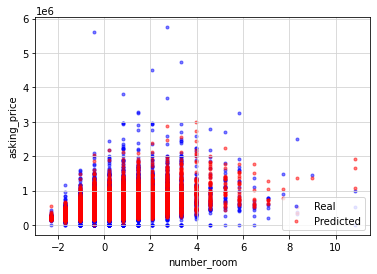

In [33]:
# Import library for visualization
import matplotlib.pyplot as plt

# Define x axis
x_axis = X_test['number_room']

# Build scatterplot to see distribution of data
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('number_room')
plt.ylabel('asking_price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

The model seems to predicit relatively accurately when matched with the number of rooms of a house.  
This can be explained due to the relatively high r2 that were found in correlation to the number of rooms.

Text(0.5, 0, 'living_area_surface')

Text(0, 0.5, 'asking_price')

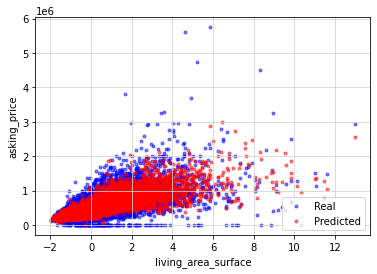

In [34]:
# Import library for visualization
import matplotlib.pyplot as plt

# Define x axis
x_axis = X_test['living_area_surface']

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('living_area_surface')
plt.ylabel('asking_price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

Similar to the number of rooms, the living area surface seems to be predicted accurately. 

## Hyperparameter Tuning

In [35]:
# get the transformed train set
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['asking_price', 'id'], axis=1) # need to drop the target! otherwise data leakage
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = fitting_splits.train_set['asking_price'] # take it from the original untransformed dataset
# create the model instance
regressor = RandomForestRegressor(n_estimators=1100, max_depth=70, random_state=101)
# fit the model instance on X_train
RF2 = regressor.fit(X=X_train, y=y_train)

In [36]:
# now we can use the fitted simple_SVC model to predict on the test dataset!
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['asking_price', 'id'], axis=1)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = fitting_splits.test_set['asking_price']
y_hat_test = regressor.predict(X_test)
# the result is a vector of predicted classes for the observations in validation, which the model was not trained on!
pd.Series(y_hat_test)

0        398473.363636
1        282461.331818
2        503597.063131
3        912337.727273
4        275229.727273
             ...      
33938    472546.954545
33939    719535.008182
33940    646427.590909
33941    293734.272727
33942    329771.828182
Length: 33943, dtype: float64

In [37]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
r2 = metrics.r2_score(y_test.values.ravel(), predictions)
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 90061.79600449512
Mean Squared Error: 23394720432.87806
Root Mean Squared Error: 152953.32762930676
R-squared scores: 0.57


Our R2 value is still relatively high and hasn't had a signficant decrease or increase from the previous one. 

### Importance level

In [38]:
# Get features list
X = df [[ 'living_area_surface' , 'aantalfotos' , 'garden', 'bedrooms','energy_label']]
characteristics = X.columns
y = df[['asking_price']]

In [39]:
# Get the variables importances, sort them, and print the result
importances = list(regressor.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: living_area_surface  Importance: 0.48
Variable: aantalfotos          Importance: 0.07
Variable: garden               Importance: 0.06
Variable: bedrooms             Importance: 0.03
Variable: energy_label         Importance: 0.02


In [40]:
#creating validation data
#X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['asking_price', 'id'], axis=1)
#y_validation = fitting_splits.validation_set['asking_price']
#X_train_validation = pd.concat([X_train, X_validation])
#y_train_validation = pd.concat([y_train, fitting_splits.validation_set['asking_price']])

# creating the model instance
#regressor = RandomForestRegressor(n_estimators=1000, max_depth=70, random_state=101)
# fitting the model instance on X_train
#RF2 = regressor.fit(X=X_train, y=y_train)

In [41]:
#using PredefinedSplit to specify which observations are train and which are validation
#fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

From this analysis we can see that the model finds the above factors to be most important for the asking price, where the living area surface seems to have a significant role on the performance of predicting the asking price. 


# Modeling with neural networks

To possibly improve on the above model, we try to perform a simple feed-forward neural network.  
For this we need scipy and keras packages installed in the environment. Moreover, we need to have a keras backend (Theano or Tensorflow) installed. We decided to use Tensorflow.  
If scipy and tensorflow keras have not been installed, use the following commands:  
- conda install scipy
- pip install tensorflow keras

In [42]:
#pip install keras

In [43]:
#pip install tensorflow keras

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [45]:
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

tensorflow: 2.7.0


In [46]:
import keras
print('keras: %s' % keras.__version__)

keras: 2.7.0


In [47]:
# import what we need from keras
from keras.models import Sequential
from keras.layers import Dense

In [48]:
#Check if the amount of variables for the train and test set are similar.
print(f"Neurons Number - Input Layer: {X_train.shape[1]}")
print(f"Neurons Number - Input Layer: {X_test.shape[1]}")

Neurons Number - Input Layer: 49
Neurons Number - Input Layer: 49


In [49]:
#Make same amount of neurons (features)
X_test.columns

Index(['living_area_surface', 'property_surface', 'aantalfotos', 'number_room',
       'bedrooms', 'sell_time_cal', 'construction_year_1', 'garden_Achtertuin',
       'garden_Balkon/dakterras', 'garden_Geen tuin', 'garden_Patio/atrium',
       'garden_Tuin', 'garden_Voortuin', 'garden_Voorzieningen',
       'garden_Zijtuin', 'garden_Zonneterras', 'energy_label_A',
       'energy_label_A+', 'energy_label_A++', 'energy_label_A+++',
       'energy_label_A++++', 'energy_label_A+++++', 'energy_label_B',
       'energy_label_C', 'energy_label_D', 'energy_label_E', 'energy_label_F',
       'energy_label_G', 'type_house1_Beneden', 'type_house1_Benedenwoning',
       'type_house1_Bovenwoning', 'type_house1_Bungalow', 'type_house1_Dubbel',
       'type_house1_Eengezinswoning', 'type_house1_Galerijflat',
       'type_house1_Grachtenpand', 'type_house1_Herenhuis',
       'type_house1_Landgoed', 'type_house1_Landhuis',
       'type_house1_Maisonnette', 'type_house1_Penthouse',
       'type_house1_P

In [50]:
#Make same amount of neurons (features)
X_train.columns

Index(['living_area_surface', 'property_surface', 'aantalfotos', 'number_room',
       'bedrooms', 'sell_time_cal', 'construction_year_1', 'garden_Achtertuin',
       'garden_Balkon/dakterras', 'garden_Geen tuin', 'garden_Patio/atrium',
       'garden_Tuin', 'garden_Voortuin', 'garden_Voorzieningen',
       'garden_Zijtuin', 'garden_Zonneterras', 'energy_label_A',
       'energy_label_A+', 'energy_label_A++', 'energy_label_A+++',
       'energy_label_A++++', 'energy_label_A+++++', 'energy_label_B',
       'energy_label_C', 'energy_label_D', 'energy_label_E', 'energy_label_F',
       'energy_label_G', 'type_house1_Beneden', 'type_house1_Benedenwoning',
       'type_house1_Bovenwoning', 'type_house1_Bungalow', 'type_house1_Dubbel',
       'type_house1_Eengezinswoning', 'type_house1_Galerijflat',
       'type_house1_Grachtenpand', 'type_house1_Herenhuis',
       'type_house1_Landgoed', 'type_house1_Landhuis',
       'type_house1_Maisonnette', 'type_house1_Penthouse',
       'type_house1_P

In [51]:
# define the neural network model class instance
simple_nn = Sequential()
# we set the number of neurons to be equal to the (# of nodes in the input layer + # neurons in the output layer)/2,
simple_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
# add the output layer
simple_nn.add(Dense(1))

2022-01-25 23:32:54.431784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
print(simple_nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
from tensorflow import keras
from tensorflow.keras import layers

In [54]:
np.isnan(np.inf) == False

True

In [55]:
#Compile a loss function for the NN
opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
simple_nn.compile(loss='mean_squared_error', optimizer = opt )

In [56]:
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['asking_price', 'id'], axis=1)
X_validation = X_validation.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_validation = fitting_splits.validation_set['asking_price']
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['asking_price', 'id'], axis=1) # We drop the target to avoid matching values that we want to predict.
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = fitting_splits.train_set['asking_price'] # Reinsert the values from the original
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['asking_price', 'id'],axis=1)
y_test = fitting_splits.test_set['asking_price']
# create the model instance

In [57]:
#Identify if shapes of the train and validation sets are similar, and if the size of the targets are 80/20 ratio.
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

(108619, 49)

(108619,)

(27155, 49)

(27155,)

In [58]:
#Fit the NN with the train set for 150 epchs in batches of 100 (25000 iterations)
simple_nn.fit(X_train, y_train, epochs=250, batch_size = 100)

Epoch 1/250
1087/1087 [==============================] - 2s 1ms/step - loss: 220291842048.0000
Epoch 2/250
1087/1087 [==============================] - 1s 1ms/step - loss: 220289826816.0000
Epoch 3/250
1087/1087 [==============================] - 1s 986us/step - loss: 220286664704.0000
Epoch 4/250
1087/1087 [==============================] - 1s 1ms/step - loss: 220282519552.0000
Epoch 5/250
1087/1087 [==============================] - 1s 1ms/step - loss: 220277456896.0000
Epoch 6/250
1087/1087 [==============================] - 1s 1ms/step - loss: 220271493120.0000
Epoch 7/250
1087/1087 [==============================] - 1s 989us/step - loss: 220264497152.0000
Epoch 8/250
1087/1087 [==============================] - 1s 990us/step - loss: 220256288768.0000
Epoch 9/250
1087/1087 [==============================] - 1s 1ms/step - loss: 220247097344.0000
Epoch 10/250
1087/1087 [==============================] - 1s 987us/step - loss: 220236759040.0000
Epoch 11/250
1087/1087 [=================

Note that when we fit the model, keras prints the value of the loss function at the end of each epoch. Here, the value of the loss function is calculated on the training set itself.
You can see that the loss is monotonically decreasing over the epochs, without slowing down the rate.

dict_keys(['loss'])

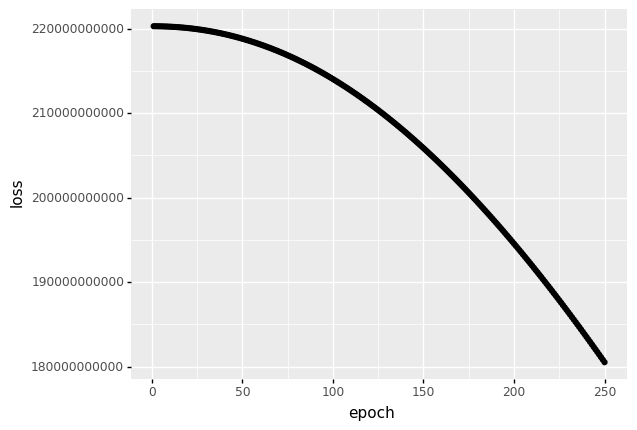

<ggplot: (8765342871923)>

In [59]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 251))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

We can see that the training loss is decreasing at an increasing rate after each epoch.  
Potentially we could increase the amount of epochs to lower the loss further since we are not close to plateauing. 

In [60]:
simple_nn.fit(X_validation, y_validation, epochs=250, batch_size = 100)

Epoch 1/250
272/272 [==============================] - 0s 731us/step - loss: 178122604544.0000
Epoch 2/250
272/272 [==============================] - 0s 716us/step - loss: 178046009344.0000
Epoch 3/250
272/272 [==============================] - 0s 706us/step - loss: 177969758208.0000
Epoch 4/250
272/272 [==============================] - 0s 714us/step - loss: 177893883904.0000
Epoch 5/250
272/272 [==============================] - 0s 710us/step - loss: 177816928256.0000
Epoch 6/250
272/272 [==============================] - 0s 713us/step - loss: 177740578816.0000
Epoch 7/250
272/272 [==============================] - 0s 774us/step - loss: 177663606784.0000
Epoch 8/250
272/272 [==============================] - 0s 692us/step - loss: 177586733056.0000
Epoch 9/250
272/272 [==============================] - 0s 769us/step - loss: 177510678528.0000
Epoch 10/250
272/272 [==============================] - 0s 675us/step - loss: 177433493504.0000
Epoch 11/250
272/272 [===========================

dict_keys(['loss'])

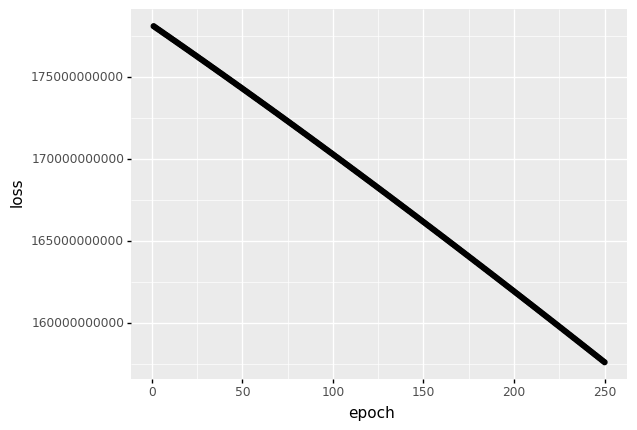

<ggplot: (8765336039283)>

In [61]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 251))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

In [62]:
#Similar to the training set, however trying out less epochs with bigger batch size (22500 iterations)
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 150, validation_data=(X_validation, y_validation), validation_split=0.1)

Epoch 1/150
652/652 [==============================] - 1s 1ms/step - loss: 160270516224.0000 - val_loss: 154240450560.0000
Epoch 2/150
652/652 [==============================] - 1s 1ms/step - loss: 160057442304.0000 - val_loss: 154028589056.0000
Epoch 3/150
652/652 [==============================] - 1s 1ms/step - loss: 159843893248.0000 - val_loss: 153817268224.0000
Epoch 4/150
652/652 [==============================] - 1s 914us/step - loss: 159630508032.0000 - val_loss: 153605406720.0000
Epoch 5/150
652/652 [==============================] - 1s 945us/step - loss: 159416516608.0000 - val_loss: 153393577984.0000
Epoch 6/150
652/652 [==============================] - 1s 947us/step - loss: 159202066432.0000 - val_loss: 153181601792.0000
Epoch 7/150
652/652 [==============================] - 1s 970us/step - loss: 158988894208.0000 - val_loss: 152969461760.0000
Epoch 8/150
652/652 [==============================] - 1s 927us/step - loss: 158774394880.0000 - val_loss: 152757338112.0000
Epoch 

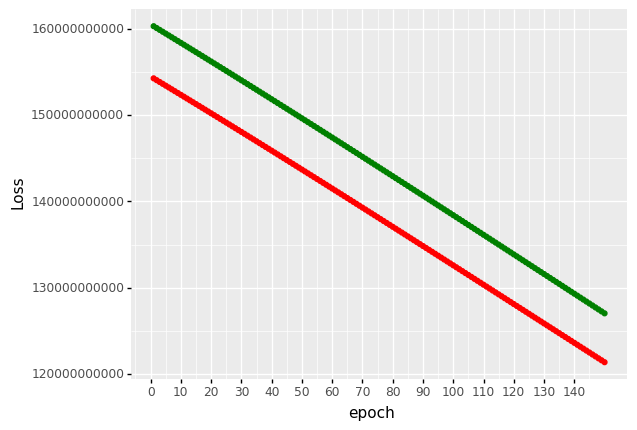

<ggplot: (8765336718599)>

In [63]:
# plot the training loss over epochs
def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch = np.arange(1, 151))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks = np.arange(0, 150, 10)) +
        ylab("Loss")
    )
    return p

plot_loss(simple_nn)

In [64]:
# saving the above simple nn fitted model using a keras save command
simple_nn.save('../dataset/simple_nn_model')

print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

2022-01-25 23:41:09.841478: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../dataset/simple_nn_model/assets
Storing the fitting history of simple nn to disk


In [65]:
# we can load the above save model like this:
simple_nn = keras.models.load_model("../dataset/simple_nn_model")
simple_nn

# reload the fitting history like this
with open("../dataset/simple_nn_history.json", "r") as handle:
    simple_nn_history = json.load(handle)

In [66]:
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['asking_price']])

After we have determined at least the number of epochs that give us the best results on the validation dataset, we can train the model on the full train + validation set, and predict on the test set to get a final value for the model performance.

In [67]:
final_nn = Sequential()
final_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
final_nn.add(Dense(1, activation='relu'))
final_nn.compile(loss='mean_squared_error', optimizer= opt)
final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size = 20, verbose=0)
y_hat_test_nn = final_nn.predict(X_test)
y_hat_test_nn = np.where(y_hat_test_nn >= 0.5, 1, 0)
r2_nn = metrics.r2_score(y_test.values.ravel(), y_hat_test_nn)
print('R-squared scores:', round(r2_nn, 2))

R-squared scores: -2.84


The R2 has dropped and became negative, we do not know how this has happened but most likely the NN couldn't find a proper way to accuratly predict the asking price.

In [68]:
#Overfitting the funda dataset to check the results we would get in case of overfitting. 
oversized_nn = Sequential()
oversized_nn.add(Dense(60, input_dim=X_train.shape[1], activation='relu'))
oversized_nn.add(Dense(40, activation='relu'))
oversized_nn.add(Dense(15, activation='relu'))
oversized_nn.add(Dense(1)) #, activation='sigmoid'
oversized_nn.compile(loss="mean_squared_error", optimizer="adam")
oversized_nn.fit(X_train, y_train, epochs=150, batch_size = 20, validation_data=(X_validation, y_validation))

Epoch 1/150
5431/5431 [==============================] - 8s 1ms/step - loss: 53619924992.0000 - val_loss: 27961378816.0000
Epoch 2/150
5431/5431 [==============================] - 8s 1ms/step - loss: 29372225536.0000 - val_loss: 26359474176.0000
Epoch 3/150
5431/5431 [==============================] - 7s 1ms/step - loss: 28405757952.0000 - val_loss: 25795377152.0000
Epoch 4/150
5431/5431 [==============================] - 7s 1ms/step - loss: 27988275200.0000 - val_loss: 25497829376.0000
Epoch 5/150
5431/5431 [==============================] - 10s 2ms/step - loss: 27737438208.0000 - val_loss: 25281581056.0000
Epoch 6/150
5431/5431 [==============================] - 7s 1ms/step - loss: 27568650240.0000 - val_loss: 25170651136.0000
Epoch 7/150
5431/5431 [==============================] - 6s 1ms/step - loss: 27420291072.0000 - val_loss: 25012299776.0000
Epoch 8/150
5431/5431 [==============================] - 7s 1ms/step - loss: 27296032768.0000 - val_loss: 25028585472.0000
Epoch 9/150
543

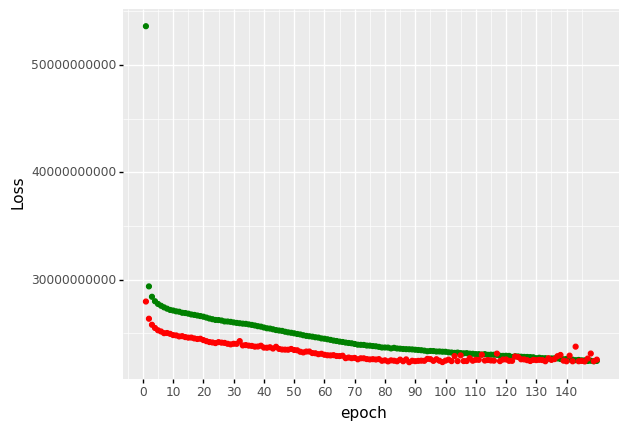

<ggplot: (8765338975672)>

In [69]:
plot_loss(oversized_nn)

We can see that the neural network is good at predicting the asking price for the set it knows the values of. In this case, we can see that the training curve performs a similar pattern to the validation one. 

## Hypertuning of neural network: batches, epochs, layers

In [70]:
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from sklearn.ensemble import VotingClassifier

In [71]:
# function that creates the model
# note that we pass the number of neurons as a parameter to the network
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))
    nn_model.add(Dense(1, activation='relu'))
    nn_model.compile(loss='mean_squared_error', optimizer = opt  )
    return nn_model

seed = 1234
np.random.seed(seed)

# turn the keras model into a sklearn compatible model
model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [72]:
# define the grid search parameters
batch_size = [10, 20]
epochs = [50, 150]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [78]:
classifier.fit(X_train, y_train)

NameError: name 'classifier' is not defined

In [77]:
start_time = datetime.datetime.now()
grid_search_nn = GridSearchCV(estimator=model.compile, param_grid=params_grid, n_jobs=-1, cv=3)
grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
end_time = datetime.datetime.now()
print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')
     #store the results of the grid search to disk

AttributeError: 'KerasClassifier' object has no attribute 'compile'